# 1. EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 윈도우 : "Malgun Gothic"
# 맥 : "AppleGothic"
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux(colab)
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family

# 폰트설정
plt.rc("font", family=get_font_family())
# 마이너스폰트 설정
plt.rc("axes", unicode_minus=False)

## 1-1. 메타버스 부동산 가격 데이터

In [3]:
# 메타버스 최초 크롤링데이터
df = pd.read_csv("meta_data_all_min.csv") 

In [4]:
# 특정 컬럼 유니크 값 개수 확인 >> 불필요한 컬럼 제거 목적
df["createdAt"].value_counts()

2021-09-16T08:44:50.296Z    7
2021-10-08T09:09:01.262Z    6
2021-11-04T11:59:37.047Z    6
2021-12-03T14:25:02.644Z    6
2021-11-08T09:28:56.826Z    6
                           ..
2021-09-26T07:02:22.150Z    1
2021-10-04T23:54:48.072Z    1
2021-11-12T06:49:52.554Z    1
2021-12-07T03:20:15.270Z    1
2021-12-06T06:04:23.672Z    1
Name: createdAt, Length: 41758, dtype: int64

In [5]:
# df[["createdAt","totalPrice"]].sort_values("createdAt")

In [6]:
# 한국 서울 주소지 값만 추출
df_korea = df[df["address"].str.contains("Seoul")==True]
df_korea.head(1)

,Unnamed: 0,isMyTile,lastPage,currentPage,allSellOrdersCount,currentSellOrderCount,sellOrderId,uuid,boughtPrice,totalPrice,createdAt,sellerId,sellerReferralCode,memo,address,coordinates
1,1,False,5297,1,52968,2,377297,056274a0-4a2d-45e0-bc93-43062e74ac60,16348160,32696320,2021-12-13T14:31:35.935Z,17253,ohKCKOZT50RU,Jamsil-dong,South Korea Seoul Songpa-gu 05608 Jamsil-dong ...,"[127.09868431091309, 37.51047477627239]"


In [7]:
# 구별로 나타내기
df_gu_list = df_korea["address"].to_list()

a = []
for i in range(len(df_gu_list)):
    gu_list = df_gu_list[i].split()[3]
    a.append(gu_list)

df_korea["gu_address"] = a
df_korea.head(1)

,Unnamed: 0,isMyTile,lastPage,currentPage,allSellOrdersCount,currentSellOrderCount,sellOrderId,uuid,boughtPrice,totalPrice,createdAt,sellerId,sellerReferralCode,memo,address,coordinates,gu_address
1,1,False,5297,1,52968,2,377297,056274a0-4a2d-45e0-bc93-43062e74ac60,16348160,32696320,2021-12-13T14:31:35.935Z,17253,ohKCKOZT50RU,Jamsil-dong,South Korea Seoul Songpa-gu 05608 Jamsil-dong ...,"[127.09868431091309, 37.51047477627239]",Songpa-gu


In [8]:
# 센트 > 달러 > 원 단위 환산
df_korea["totalPrice/100*1200"] = df_korea["totalPrice"]/100*1200
df_korea["boughtPrice/100*1200"] = df_korea["boughtPrice"]/100*1200
df_korea.head(1)

,Unnamed: 0,isMyTile,lastPage,currentPage,allSellOrdersCount,currentSellOrderCount,sellOrderId,uuid,boughtPrice,totalPrice,createdAt,sellerId,sellerReferralCode,memo,address,coordinates,gu_address,totalPrice/100*1200,boughtPrice/100*1200
1,1,False,5297,1,52968,2,377297,056274a0-4a2d-45e0-bc93-43062e74ac60,16348160,32696320,2021-12-13T14:31:35.935Z,17253,ohKCKOZT50RU,Jamsil-dong,South Korea Seoul Songpa-gu 05608 Jamsil-dong ...,"[127.09868431091309, 37.51047477627239]",Songpa-gu,392355840.0,196177920.0


In [9]:
# 불필요한 컬럼 제거
df_1 = df_korea.drop(["uuid","Unnamed: 0","sellOrderId","allSellOrdersCount","lastPage","currentPage","currentSellOrderCount","isMyTile","sellerReferralCode"], axis = 1)
df_1.head(1)


,boughtPrice,totalPrice,createdAt,sellerId,memo,address,coordinates,gu_address,totalPrice/100*1200,boughtPrice/100*1200
1,16348160,32696320,2021-12-13T14:31:35.935Z,17253,Jamsil-dong,South Korea Seoul Songpa-gu 05608 Jamsil-dong ...,"[127.09868431091309, 37.51047477627239]",Songpa-gu,392355840.0,196177920.0


In [10]:
# 필요한 컬럼 추출 : 메타버스 시장가격 (단위 : 센트>달러>원 , 고정환율 : 1,200원)
df_meta = pd.DataFrame()
df_meta["boughtPrice"] = df_1["boughtPrice/100*1200"]
df_meta["totalPrice"] = df_1["totalPrice/100*1200"]
df_meta["gu_address"] = df_1["gu_address"]
df_meta["dong_address"] = df_1["memo"]

# df_meta_index = df_meta.set_index(['gu_address','dong_address'])
df_meta

,boughtPrice,totalPrice,gu_address,dong_address
1,196177920.0,392355840.0,Songpa-gu,Jamsil-dong
2,176821632.0,353643552.0,Songpa-gu,Sincheon-dong
4,133792656.0,267585312.0,Songpa-gu,Sincheon-dong
5,122780448.0,245560896.0,Yeongdeungpo-gu,Yeouido-dong
7,103072632.0,206145264.0,Songpa-gu,Sincheon-dong
...,...,...,...,...
49408,240.0,480.0,Gangseo-gu,Magok-dong
49821,240.0,480.0,Gangnam-gu,Dogok-dong
49962,240.0,480.0,Yongsan-gu,Ichon-dong
50178,240.0,480.0,Gangseo-gu,Magok-dong


## 1-2. 현실 부동산 가격 데이터

In [11]:
# 현실 공시지가 데이터  (출처 : http://stat.molit.go.kr/portal/cate/statView.do?hRsId=25&hFormId=6214&hSelectId=6214&sStyleNum=1&sStart=2020&sEnd=2020&hPoint=0&hAppr=1&oFileName=&rFileName=&midpath=)
df_real = pd.read_excel("01.토지_소유구분별_기본_현황_시군구.xlsx")

df_real = df_real[["시도", "시군구","합 계", "Unnamed: 3","Unnamed: 4"]]
df_real.columns = ["시도","시군구","면적", "지번수","가액"]
df_real = df_real.iloc[3:28, 0:6].fillna("서울특별시")



공식 : 가액 = 면적 * (지분) * 개별공시지가 * 50/100   (국유지랑 사유지가 모두 포함되어 있기 때문에, 지분은 1로 계산함)

따라서, 가액 * 2 / 면적 = 개별공시지가

In [12]:
# df_real 데이터 프레임의 단위 > 면적 : km^2 , 가액 : 10억원
# 면적 단위 km^2 > m^2 로 맞추기
df_real["면적"] = df_real["면적"] * 1000000


# 개별공시지가 (단위 : 10억원)
df_real["개별공시지가"] = df_real["가액"] * 2 / df_real["면적"]
df_real["TP"] = df_real["가액"] * 2
df_real

,시도,시군구,면적,지번수,가액,개별공시지가,TP
3,서울특별시,종로구,23913168.3,49.277,73699.545799,0.006164,147399.091598
4,서울특별시,중구,9960304.5,35.692,91727.388150,0.018419,183454.776300
5,서울특별시,용산구,21866144.1,45.009,86386.603768,0.007901,172773.207537
6,서울특별시,성동구,16861003.9,26.882,51293.696805,0.006084,102587.393609
7,서울특별시,광진구,17062938.6,32.794,46846.790664,0.005491,93693.581329
8,서울특별시,동대문구,14215623.5,41.514,42029.893060,0.005913,84059.786119
9,서울특별시,중랑구,18496082.3,40.347,30436.009433,0.003291,60872.018867
10,서울특별시,성북구,24576832.9,55.493,49116.527028,0.003997,98233.054056
11,서울특별시,강북구,23600354.9,40.560,26022.648743,0.002205,52045.297486
12,서울특별시,도봉구,20651081.9,22.640,24557.233140,0.002378,49114.466280


# 2. 데이터 분석

메타버스2 가상부동산 가격형성에는 어떤 요인이 영향을 줄까?

## 2-1. 가설1 : 현실 부동산(토지)가격이 메타버스2 가상부동산 가격형성과 관계가 있다.

In [13]:
df_col = df_real[["TP","시군구"]]
df_col.head(1)

,TP,시군구
3,147399.091598,종로구


In [14]:

df_col_a = []
for i in ["Jongno-gu", "Jung-gu", "Yongsan-gu", "Seongdong-gu", "Gwangjin-gu", "Dongdaemun-gu", "Jungnang-gu", 
          "Seongbuk-gu", "Gangbuk-gu", "Dobong-gu", "Nowon-gu", "Eunpyeong-gu", "Seodaemun-gu", "Mapo-gu",
          "Yangcheon-gu", "Gangseo-gu", "Guro-gu", "Geumcheon-gu", "Yeongdeungpo-gu", "Dongjak-gu" , "Gwanak-gu", 
          "Seocho-gu", "Gangnam-gu", "Songpa-gu", "Gangdong-gu"]:
    a = df_meta[df_meta["gu_address"] == i]["totalPrice"].sum()
    df_col_a.append(a)
    
df_col["meta_tp"] = df_col_a
df_col.head(1)

,TP,시군구,meta_tp
3,147399.091598,종로구,5.294591e+09


In [15]:
# 스케일이 차이가 큰 상태로 시각화할 경우, 데이터를 읽기 어려울 수 있기 때문에 Log를 씌워 데이터 스케일 차이를 줄이고 데이터를 읽기 위함 
df_col["real_tp_log"] = np.log(df_col["TP"])
df_col["meta_tp_log"] = np.log(df_col["meta_tp"])
df_col


,TP,시군구,meta_tp,real_tp_log,meta_tp_log
3,147399.091598,종로구,5.294591e+09,11.900899,22.389952
4,183454.776300,중구,2.598204e+09,12.119723,21.678086
5,172773.207537,용산구,2.825548e+09,12.059735,21.761968
6,102587.393609,성동구,8.259247e+08,11.538470,20.532014
7,93693.581329,광진구,2.128154e+08,11.447785,19.175936
8,84059.786119,동대문구,1.045344e+08,11.339284,18.465027
9,60872.018867,중랑구,1.340024e+08,11.016529,18.713368
10,98233.054056,성북구,5.825838e+08,11.495098,20.182984
11,52045.297486,강북구,1.654944e+08,10.859870,18.924448
12,49114.466280,도봉구,7.484482e+07,10.801909,18.130927


<AxesSubplot:xlabel='real_tp_log', ylabel='meta_tp_log'>

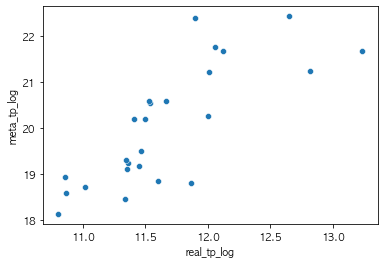

In [16]:
sns.scatterplot(data = df_col, x = 'real_tp_log', y = 'meta_tp_log')

<AxesSubplot:xlabel='real_tp_log', ylabel='meta_tp_log'>

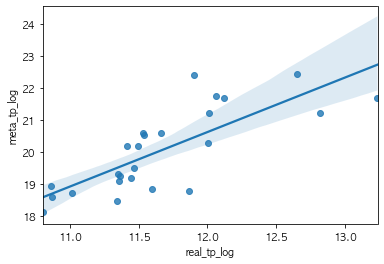

In [17]:
sns.regplot(data = df_col, x = 'real_tp_log', y = 'meta_tp_log')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [Text(0, 0, '종로구'),
  Text(1, 0, '중구'),
  Text(2, 0, '용산구'),
  Text(3, 0, '성동구'),
  Text(4, 0, '광진구'),
  Text(5, 0, '동대문구'),
  Text(6, 0, '중랑구'),
  Text(7, 0, '성북구'),
  Text(8, 0, '강북구'),
  Text(9, 0, '도봉구'),
  Text(10, 0, '노원구'),
  Text(11, 0, '은평구'),
  Text(12, 0, '서대문구'),
  Text(13, 0, '마포구'),
  Text(14, 0, '양천구'),
  Text(15, 0, '강서구'),
  Text(16, 0, '구로구'),
  Text(17, 0, '금천구'),
  Text(18, 0, '영등포구'),
  Text(19, 0, '동작구'),
  Text(20, 0, '관악구'),
  Text(21, 0, '서초구'),
  Text(22, 0, '강남구'),
  Text(23, 0, '송파구'),
  Text(24, 0, '강동구')])

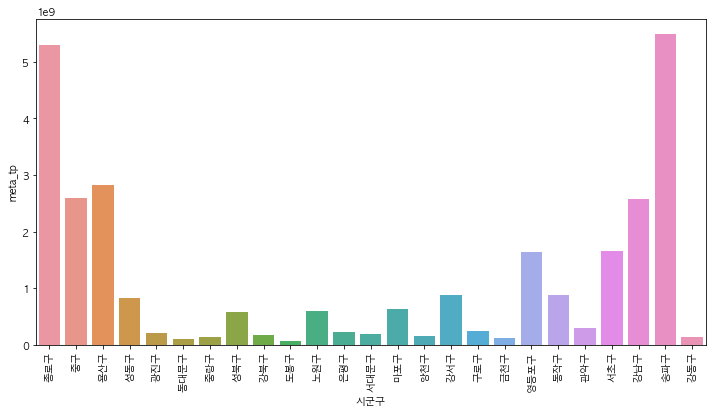

In [18]:
plt.figure(figsize=(12,6))
sns.barplot(data = df_col, x = '시군구', y = 'meta_tp') 
plt.xticks(rotation=90)
# barplot은 로그값을 적용한 데이터로 시각화할 경우에 읽기 어려움

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [Text(0, 0, '종로구'),
  Text(1, 0, '중구'),
  Text(2, 0, '용산구'),
  Text(3, 0, '성동구'),
  Text(4, 0, '광진구'),
  Text(5, 0, '동대문구'),
  Text(6, 0, '중랑구'),
  Text(7, 0, '성북구'),
  Text(8, 0, '강북구'),
  Text(9, 0, '도봉구'),
  Text(10, 0, '노원구'),
  Text(11, 0, '은평구'),
  Text(12, 0, '서대문구'),
  Text(13, 0, '마포구'),
  Text(14, 0, '양천구'),
  Text(15, 0, '강서구'),
  Text(16, 0, '구로구'),
  Text(17, 0, '금천구'),
  Text(18, 0, '영등포구'),
  Text(19, 0, '동작구'),
  Text(20, 0, '관악구'),
  Text(21, 0, '서초구'),
  Text(22, 0, '강남구'),
  Text(23, 0, '송파구'),
  Text(24, 0, '강동구')])

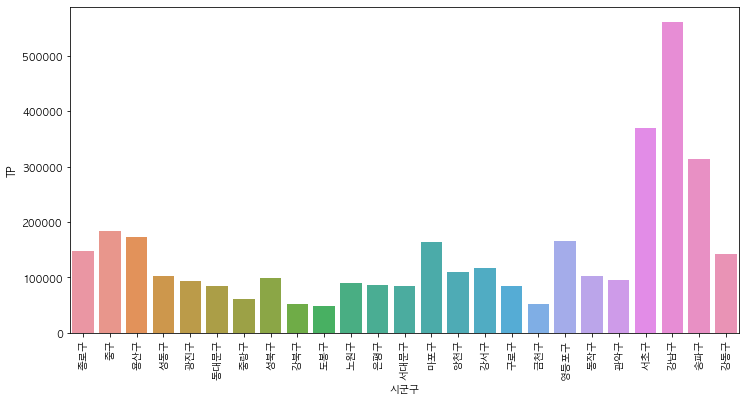

In [19]:
plt.figure(figsize=(12,6))
sns.barplot(data = df_col, x = '시군구', y = 'TP') # barplot은 로그값을 적용한 데이터로 시각화할 경우에 읽기 어려움
plt.xticks(rotation=90)

1. 스피어만 상관분석 진행

In [20]:
df_rank = pd.DataFrame()

df_rank["meta"] = df_col['meta_tp_log'].rank(method='max', ascending=False)
df_rank["real"] = df_col['real_tp_log'].rank(method='max', ascending=False)
df_rank["gu"] = df_col["시군구"]

df_rank

,meta,real,gu
3,2.0,8.0,종로구
4,4.0,4.0,중구
5,3.0,5.0,용산구
6,10.0,12.0,성동구
7,17.0,16.0,광진구
8,24.0,21.0,동대문구
9,22.0,22.0,중랑구
10,13.0,14.0,성북구
11,19.0,24.0,강북구
12,25.0,25.0,도봉구


In [21]:
A = df_rank["meta"]
B = df_rank["real"]

In [22]:
stats.spearmanr(A, B)

# https://hyen4110.tistory.com/38
# https://bskyvision.com/754

SpearmanrResult(correlation=0.8307692307692308, pvalue=2.736366723847707e-07)

> 현실의 부동산 토지가격과 메타버스2 가상부동산 토지의 가격을 상관분석했을때, 0.83의 상관관계를 알 수 있음 \
> 즉, 어느정도 현실의 부동산 토지가격과 메타버스2 가상부동산 토지의 가격이 서로 연관성이 있다는 것을 알 수 있다.


* 자세히 살펴보기 위해, 현재 메타버스2 플랫폼 내에서의 서비스 요인인 랜드마크를 제거하고 상관분석 진행

In [45]:
# 랜드마크 요인 제거
df_col_land = df_col.copy()
df_col_land.drop(["meta_tp_log"], axis = 1)

# 1)현재서비스요인 : 랜드마크 , 2)향후서비스요인 : 산, 강 > 2가지 요인을 모두 제외한 TP (랜드마크가 속한 5개 구)
df_col_land.loc[df_col_land['시군구'] == "중구", 'meta_tp'] = 1.406463e+09 
df_col_land.loc[df_col_land['시군구'] == "용산구", 'meta_tp'] = 9.144154e+08
df_col_land.loc[df_col_land['시군구'] == "성동구", 'meta_tp'] = 3.960063e+08
df_col_land.loc[df_col_land['시군구'] == "송파구", 'meta_tp'] = 1.667442e+09
df_col_land.loc[df_col_land['시군구'] == "종로구", 'meta_tp'] = 2.362390e+09


df_col_land["meta_tp_log_land"] = np.log(df_col_land["meta_tp"])
df_col_land
# df_col_landmin["meta_tp_log_min"] = np.log(df_col_landmin["meta_tp"])
# df_col_landmin

,TP,시군구,meta_tp,real_tp_log,meta_tp_log,meta_tp_log_land
3,147399.091598,종로구,2.362390e+09,11.900899,22.389952,21.582940
4,183454.776300,중구,1.406463e+09,12.119723,21.678086,21.064344
5,172773.207537,용산구,9.144154e+08,12.059735,21.761968,20.633796
6,102587.393609,성동구,3.960063e+08,11.538470,20.532014,19.796941
7,93693.581329,광진구,2.128154e+08,11.447785,19.175936,19.175936
8,84059.786119,동대문구,1.045344e+08,11.339284,18.465027,18.465027
9,60872.018867,중랑구,1.340024e+08,11.016529,18.713368,18.713368
10,98233.054056,성북구,5.825838e+08,11.495098,20.182984,20.182984
11,52045.297486,강북구,1.654944e+08,10.859870,18.924448,18.924448
12,49114.466280,도봉구,7.484482e+07,10.801909,18.130927,18.130927


<AxesSubplot:xlabel='real_tp_log', ylabel='meta_tp_log_land'>

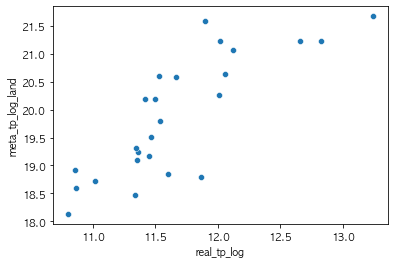

In [46]:

sns.scatterplot(data = df_col_land, x = 'real_tp_log', y = 'meta_tp_log_land')

In [24]:
df_rank_land = pd.DataFrame()

df_rank_land["meta_land"] = df_col_land['meta_tp_log_land'].rank(method='max', ascending=False)
df_rank_land["real_land"] = df_col_land['real_tp_log'].rank(method='max', ascending=False)
df_rank_land["gu"] = df_col_land["시군구"]

df_rank_land

,meta_land,real_land,gu
3,2.0,8.0,종로구
4,6.0,4.0,중구
5,7.0,5.0,용산구
6,13.0,12.0,성동구
7,17.0,16.0,광진구
8,24.0,21.0,동대문구
9,22.0,22.0,중랑구
10,12.0,14.0,성북구
11,19.0,24.0,강북구
12,25.0,25.0,도봉구


In [25]:
C = df_rank_land["meta_land"]
D = df_rank_land["real_land"]

In [26]:
stats.spearmanr(C, D)

SpearmanrResult(correlation=0.8400000000000001, pvalue=1.506164347046491e-07)

> 랜드마크 요인을 빼고 분석한 결과 이전 결과대비 약간 상승한 0.84의 상관관계를 알 수 있음 \
> 즉, 어느정도 현실의 부동산 토지가격과 메타버스2 가상부동산 토지의 가격이 \
> 랜드마크라는 서비스요인을 제외하고도 서로 연관성이 있다는 것을 알 수 있다.

## 2-2. 가설2 : 메타버스2 '랜드마크'라는 서비스 요인이 가상부동산 가격형성에 영향을 준다.

### 2-2-1. 메타버스2의 서비스 요인 분석 : 확정 랜드마크

* 실제 서울시 면적 : 605km^2 = 650000000m^2
* 실제 뉴욕시 면적 : 1214.4km^2 = 1214400000m^2
* 실제 서울시 면적 : 실제 뉴욕시 면적 = 1 : 1.87

In [27]:
# 메타버스2 가상부동산 서울시 전체 TP
df_meta["totalPrice"].sum()

28562316504.0

In [28]:
# 메타버스2 가상부동산 서울시 랜드마크가 속한 구 TP
a_gu = df_meta[df_meta["gu_address"] == "Jung-gu"]["totalPrice"].sum() # 2598203928 원
b_gu = df_meta[df_meta["gu_address"] == "Yongsan-gu"]["totalPrice"].sum()  # 2825548392 원
c_gu = df_meta[df_meta["gu_address"] == "Seongdong-gu"]["totalPrice"].sum()  # 825924732 원
d_gu = df_meta[df_meta["gu_address"] == "Songpa-gu"]["totalPrice"].sum()  # 5490518904 원
e_gu = df_meta[df_meta["gu_address"] == "Jongno-gu"]["totalPrice"].sum()  # 5294590824 원

land_sum_gu = a_gu + b_gu + c_gu + d_gu + e_gu
land_sum_gu

17034786780.0

In [29]:
land_sum_gu / df_meta["totalPrice"].sum() * 100

59.64077450655786

* 메타버스2 서울시 전체 25개구 중, 가상부동산 가격의 약 60%가 랜드마크가 속한 5개에서 나타남.  

In [30]:
# 메타버스2 서울시 확정 랜드마크 8개 TP
# 메타버스2 서울시내 랜드마크가 있는 구 : 중구, 용산구, 성동구, 송파구, 종로구 (총 5곳) 

df_land_gu_sum = {}
df_land_gu_sum["중구_TP"] = df_meta[df_meta["gu_address"] == "Jung-gu"]["totalPrice"].sum() # 2598203928 원
df_land_gu_sum["용산구_TP"] = df_meta[df_meta["gu_address"] == "Yongsan-gu"]["totalPrice"].sum()  # 2825548392 원
df_land_gu_sum["성동구_TP"] = df_meta[df_meta["gu_address"] == "Seongdong-gu"]["totalPrice"].sum()  # 825924732 원
df_land_gu_sum["송파구_TP"] = df_meta[df_meta["gu_address"] == "Songpa-gu"]["totalPrice"].sum()  # 5490518904 원
df_land_gu_sum["종로구_TP"] = df_meta[df_meta["gu_address"] == "Jongno-gu"]["totalPrice"].sum()  # 5294590824 원

df_land_gu_tp = pd.DataFrame([df_land_gu_sum]) # 랜드마크가 속한 지역구 TP
df_land_gu_tp

,중구_TP,용산구_TP,성동구_TP,송파구_TP,종로구_TP
0,2.598204e+09,2.825548e+09,825924732.0,5.490519e+09,5.294591e+09


각 랜드마크별 TotalPrice 
1. 종묘 (TP: 2672553.29 달러, 타일수: 861개, 상품수: 313개) 
2. 시청 (TP: 460616.43 달러, 타일수: 124개, 상품수: 57개) 
3. 덕수궁 (TP: 576830.4 달러, 타일수: 156개, 상품수: 115개) 
4. 국립중앙박물관 (TP: 901849.13 달러, 타일수: 302개, 상품수: 233개) 
5. 롯데타워 (TP: 2217947.39 달러, 타일수: 160개, 상품수: 91개) 
6. 롯데월드 (TP: 1740743.69 달러, 타일수: 299개, 상품수: 91개) 
7. 한남 (TP: 718994.93 달러, 타일수: 229개, 상품수: 190개) 
8. 트리마제 (TP: 472134.9 달러, 타일수: 158개, 상품수: 143개)

In [31]:
# 랜드마크
landmark = pd.read_csv("2.확정랜드마크_데이터셋.csv")
landmark

,랜드마크,TP_달러,타일 수,면적,TP_원
0,종묘_종로구,2672553.29,861,86100,3207063948
1,시청_중구,460616.43,124,12400,552739716
2,덕수궁_중구,576830.40,156,15600,692196480
3,국립중앙박물관_용산구,901849.13,302,30200,1082218956
4,롯데타워_송파구,2217947.39,160,16000,2661536868
5,롯데월드_송파구,1740743.69,299,29900,2088892428
6,나인원한남_용산구,718994.93,229,22900,862793916
7,트리마제_성동구,472134.90,158,15800,566561880


In [32]:
# 확정랜드마크가 속한 구에서 산,강 요인에 대한 데이터 셋
land_tree = pd.read_csv("1.랜드마크(구)_산,강_데이터.csv", encoding = "cp949")
land_tree

,Unnamed: 0,산강TP(won),산강 면적(m^2),메타버스 면적,타일수
0,중구,8.390462e+07,1249360.00,624680.000,6246.80000
1,용산구,1.188512e+08,5329651.00,2664825.500,26648.25500
2,성동구,2.808683e+07,1706642.81,853321.405,8533.21405
3,송파구,2.869832e+07,3200171.86,1600085.930,16000.85930
4,종로구,4.762692e+08,100721.86,50360.930,503.60930


* 서비스 요인별 메타버스2 가상부동산 가격형성에 영향을 미치는 정도를 파악하기 위해 1)랜드마크 와 2)산,강 각각의 서비스 요인은 분리해서 분석함

1. 서울시 전체 타일수
* 서울시 605*1000*1000/2/100 = 3025000개

 
2. 랜드마크가 속한 5개구 전체 타일수
* 중구 9.96*1000*1000/2/100 = 49800개
* 용산구 21.87*1000*1000/2/100 = 109350개
* 성동구 16.84*1000*1000/2/100 = 84200개
* 송파구 33.88*1000*1000/2/100 = 169400개
* 종로구 23.91*1000*1000/2/100 = 119550개

In [33]:
# 서울 전체 TP 중, 랜드마크가 차지하는 점유율 약 41%
landmark["TP_원"].sum() / df_meta["totalPrice"].sum() * 100

41.01209434591734

In [34]:
# 서울 전체 면적 중, 랜드마크가 차지하는 점유율 약 0.08%
landmark["타일 수"].sum() / (3025000) * 100

0.0756694214876033

> 메타버스2 가상부동산 내에서 랜드마크가 차지하는 면적대비 TotalPrice를 확인해봤을때,\
> 랜드마크가 메타버스2에서 서비스 요인으로서 약512.5배이상으로 작용한다는 것을 알 수 있음

### 2-2-2. 메타버스2의 서비스 요인 분석 : 랜드마크 예상 기대지역

In [35]:
landmark_pre = pd.read_csv("3.최종 예상랜드.csv", encoding = "cp949")
land_tree_pre = pd.read_csv("4.예상랜드구_산,강 토탈.csv", encoding = "cp949")

In [36]:
# 서울 전체 TP 중, 예상 랜드마크가 차지하는 점유율 약 5%
landmark_pre["TP_원"].sum() / df_meta["totalPrice"].sum() * 100

5.064389353004419

In [37]:
# 서울 전체 면적 중, 랜드마크가 차지하는 점유율 약 0.33%
landmark_pre["타일 수"].sum() / (3025000) * 100

0.3281322314049587

 > 확정랜드마크에 비해 상대적으로 메타버스2 가상부동산 가격형성에 미치는 영향이 적지만,\
 > 면적대비 TotalPrice가 차지하는 비율이 약 16배 높은 것으로 확인됨\
 > 그러므로, 약간의 기대심리가 반영된 것으로 보임

### 2-2-3. 메타버스2의 서비스 요인 분석 : 랜드마크(확정/예상)가 가격형성에 미치는 영향

In [38]:
df_land_gu_tp # 메타버스 랜드마크가 포함된 구 TP
df_land_gu_tp.sum(axis=1)

0    1.703479e+10
dtype: float64

In [39]:
df_land_gu_tile = pd.DataFrame()

df_land_gu_tile["중구_tile"] = [49800]
df_land_gu_tile["용산구_tile"] = [109350]
df_land_gu_tile["성동구_tile"] = [84200]
df_land_gu_tile["송파구_tile"] = [169400]
df_land_gu_tile["종로구_tile"] = [119550]

df_land_gu_tile.sum(axis=1)

0    532300
dtype: int64

In [40]:
# 
df_land_gu_tp.sum(axis=1) / df_land_gu_tile.sum(axis=1)

0    32002.229532
dtype: float64

In [41]:
# 랜드마크포함된 5개구 TP / 랜드마크포함된 5개구 타일수 = 5개 구별 타일당 가격
df_land_5gu = pd.DataFrame()
land_A = []
land_B = []

for i in df_land_gu_tp:
    a = df_land_gu_tp[i]
    land_A.append(a)
df_land_5gu["land_tp"] = land_A

    
for w in df_land_gu_tile:
    b = df_land_gu_tile[w]
    land_B.append(b)
df_land_5gu["land_tile"] = land_B

df_land_5gu
# df_land_5gu["5개 타일당 가격"] = land_5gu
# df_land_5gu

,land_tp,land_tile
0,"0 2.598204e+09 Name: 중구_TP, dtype: float64","0 49800 Name: 중구_tile, dtype: int64"
1,"0 2.825548e+09 Name: 용산구_TP, dtype: float64","0 109350 Name: 용산구_tile, dtype: int64"
2,"0 825924732.0 Name: 성동구_TP, dtype: float64","0 84200 Name: 성동구_tile, dtype: int64"
3,"0 5.490519e+09 Name: 송파구_TP, dtype: float64","0 169400 Name: 송파구_tile, dtype: int64"
4,"0 5.294591e+09 Name: 종로구_TP, dtype: float64","0 119550 Name: 종로구_tile, dtype: int64"


In [42]:
df_meta

,boughtPrice,totalPrice,gu_address,dong_address
1,196177920.0,392355840.0,Songpa-gu,Jamsil-dong
2,176821632.0,353643552.0,Songpa-gu,Sincheon-dong
4,133792656.0,267585312.0,Songpa-gu,Sincheon-dong
5,122780448.0,245560896.0,Yeongdeungpo-gu,Yeouido-dong
7,103072632.0,206145264.0,Songpa-gu,Sincheon-dong
...,...,...,...,...
49408,240.0,480.0,Gangseo-gu,Magok-dong
49821,240.0,480.0,Gangnam-gu,Dogok-dong
49962,240.0,480.0,Yongsan-gu,Ichon-dong
50178,240.0,480.0,Gangseo-gu,Magok-dong


In [43]:
df_meta_songpa_dong = pd.DataFrame()

df_meta_songpa_dong["dong_tp"] = [df_meta[df_meta["dong_address"] == 'Jamsil-dong']["totalPrice"].sum(),
                           df_meta[df_meta["dong_address"] == 'Pungnap-dong']["totalPrice"].sum(),
                           df_meta[df_meta["dong_address"] == 'Geoyeo-dong']["totalPrice"].sum(),
                           df_meta[df_meta["dong_address"] == 'Macheon-dong']["totalPrice"].sum(),
                           df_meta[df_meta["dong_address"] == 'Bangi-dong']["totalPrice"].sum(),
                           df_meta[df_meta["dong_address"] == 'Ogeum-dong']["totalPrice"].sum(),
                           df_meta[df_meta["dong_address"] == 'Songpa-dong']["totalPrice"].sum(),
                           df_meta[df_meta["dong_address"] == 'Seokchon-dong']["totalPrice"].sum(),
                           df_meta[df_meta["dong_address"] == 'Samjeon-dong']["totalPrice"].sum(),
                           df_meta[df_meta["dong_address"] == 'Garak-dong']["totalPrice"].sum(),
                           df_meta[df_meta["dong_address"] == 'Munjeong-dong']["totalPrice"].sum(),
                           df_meta[df_meta["dong_address"] == 'Jangji-dong']["totalPrice"].sum(),
                           df_meta[df_meta["dong_address"] == 'Sincheon-dong']["totalPrice"].sum()]

df_meta_songpa_dong["dong_name"] = ['Jamsil-dong', 'Pungnap-dong', 'Geoyeo-dong', 'Macheon-dong', 'Bangi-dong',
                                   'Ogeum-dong', 'Songpa-dong', 'Seokchon-dong', 'Samjeon-dong',
                                   'Garak-dong', 'Munjeong-dong', 'Jangji-dong', 'Sincheon-dong']

df_meta_songpa_dong

,dong_tp,dong_name
0,2.471733e+09,Jamsil-dong
1,3.727968e+07,Pungnap-dong
2,2.602210e+07,Geoyeo-dong
3,9.996480e+06,Macheon-dong
4,1.784920e+08,Bangi-dong
5,9.349020e+06,Ogeum-dong
6,4.985068e+07,Songpa-dong
7,5.721137e+07,Seokchon-dong
8,1.662878e+07,Samjeon-dong
9,2.337013e+07,Garak-dong


In [44]:
df_meta_songpa_dong[df_meta_songpa_dong["dong_name"] == 'Sincheon-dong']['dong_tp'].sum() - landmark[landmark["랜드마크"] == "롯데타워_송파구"]["TP_원"].sum()

#롯데타워 신청동
#롯데월드 잠실동

-106655976.0

## 2-3. 가설3 : 메타버스2에는 향후(미래)서비스 요인이 가상부동산 가격형성에 영향을 준다.

메타버스2 향후 서비스 로드맵 (백서)를 살펴보면,\
미래에는 산,강 토지(타일)에서 자원을 채취하여 건물을 짓기 위한 요소를 충족시킬 수 있다고 명시함

### 2-3-1. 메타버스2의 서비스 요인 분석 : 서비스 로드맵에 기반한 향후 서비스 요인(산, 강)이 미치는 영향